In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_Markovian_PostMeanScore_fSinLog_LowFTh_T256_H05_tl_110data_StbleTgt import get_config as get_sinlog_config
from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_LowFTh_T256_H05_tl_110data_StbleTgt import get_config as get_bipot_config
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt import get_config as get_quadsin_config

In [2]:
sinlog_config = get_sinlog_config()
bipot_config = get_bipot_config()
quadsin_config = get_quadsin_config()
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [3]:
def plot_drift_estimator(config,root_dir, mean, mean_min, mean_max, numpy_Xs, true_drift, Nepoch, dirname, label, toSave: bool = True):
    if "BiPot" in config.data_path:
        ts_type_str = "fBiPot"
    elif "SinLog" in config.data_path:
        ts_type_str = "fSinLog"
    elif "QuadSinHF" in config.data_path:
        ts_type_str = "fQuadSinHF2"
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")
    ymin = mean - mean_min
    ymax = mean_max - mean
    ymin[ymin < 0.] = 0.
    ymax[ymax < 0.] = 0.
    plt.errorbar(numpy_Xs, mean, yerr=[ymin, ymax], xerr=None, fmt='o', color="blue", alpha=0.4)
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"Score Estimator for {label}", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $Y$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    if toSave:
        plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{ts_type_str}_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFac").replace(
                ".", "") + ".png", bbox_inches='tight')
    plt.show()
    plt.close()

In [4]:
def get_best_epoch(type):
    model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
    for file in os.listdir(model_dir):
        if config.scoreNet_trained_path in os.path.join(model_dir, file) and f"{type}" in file:
            print(file.split(f"{type}NEp")[-1])
            best_epoch = int(file.split(f"{type}NEp")[-1])
    return best_epoch

def get_best_eval_file(root_score_dir, ts_type, best_epoch_eval):
    for file in os.listdir(root_score_dir):
        if ("_"+str(best_epoch_eval)+"Nep") in file and "muhats" in file and ts_type in file:
            return np.load(root_score_dir+file, allow_pickle=True)

def get_best_track_file(root_score_dir, ts_type, best_epoch_track):
    for file in os.listdir(root_score_dir):
        if ("_"+str(best_epoch_track)+"Nep") in file and "true" in file and ts_type in file:
            true_file = np.load(root_score_dir+file, allow_pickle=True)
        elif ("_"+str(best_epoch_track)+"Nep") in file and "global" in file and ts_type in file:
            global_file = np.load(root_score_dir+file, allow_pickle=True)
    return true_file, global_file

def eval_exp_pipeline(root_score_dir, ts_type, config, root_dir, Xs, toSave, label, true_drifts):
    best_epoch_eval = get_best_epoch(type="Trk")
    muhats = get_best_eval_file(root_score_dir=root_score_dir, best_epoch_eval = best_epoch_eval, ts_type=ts_type)
    muhats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[2]*1)
    print(muhats.shape)
    mu_hats = muhats.mean(axis=-1)
    mu_hats_minq = np.quantile(muhats, axis=-1, q=0.005) # Lower bound
    mu_hats_maxq = np.quantile(muhats, axis=-1, q=0.995) # Upper boun
    plot_drift_estimator(root_dir=root_dir, config=config, mean=mu_hats, mean_min=mu_hats_minq, mean_max=mu_hats_maxq, dirname=ts_type, numpy_Xs=Xs,  toSave=toSave, true_drift=true_drifts, Nepoch=best_epoch_eval, label=label)
    return np.mean(np.power(mu_hats - true_drifts, 2))



def track_pipeline(root_score_dir, ts_type, config, root_dir, toSave, label):
    best_epoch_track = get_best_epoch(type="EE")
    if best_epoch_track % 2 != 0: best_epoch_track -= 1
    all_true_states, all_global_states = get_best_track_file(root_score_dir=root_score_dir, ts_type=ts_type, best_epoch_track=best_epoch_track)
    print(all_true_states.shape)
    time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
    all_global_errors = np.sum(np.power(all_true_states- all_global_states,2), axis=-1)
    all_global_errors = all_global_errors.reshape(-1, all_global_errors.shape[-1])
    total_global_errors = np.sqrt(np.mean((all_global_errors), axis=0))/np.sqrt(time_steps)
    all_errs = np.sqrt(all_global_errors)/np.sqrt(time_steps)
    total_global_errors[np.isinf(total_global_errors)] = 0.
    all_errs[np.isinf(all_errs)] = 0.
    total_global_errors_minq, total_global_errors_maxq = np.quantile(all_errs, axis=0,q=[0.005,0.995])
    fig, ax = plt.subplots(figsize=(14,9))
    plt.grid(True)
    ax.scatter(time_steps, total_global_errors)
    plt.fill_between(time_steps,y1=total_global_errors_minq, y2=total_global_errors_maxq, color="blue", alpha=0.4)
    ax.set_title(f"Pathwise RMSE for Score Estimator for {label}",fontsize=40)

    ax.set_xlabel("Time Axis", fontsize=38)
    ax.tick_params(labelsize=38)

    fig.canvas.draw()
    # Get the offset text (e.g., '1e-5')
    offset_text = ax.yaxis.get_offset_text().get_text()

    # Remove the offset text from the axis
    ax.yaxis.get_offset_text().set_visible(False)

    # Inject the scale into the y-axis label
    if offset_text:
        ax.set_ylabel(f'RMSE ({offset_text})', fontsize=38)
    else:
        ax.set_ylabel('RMSE', fontsize=38)
    plt.tight_layout()
    if toSave:
        plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{ts_type}/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{ts_type}_DriftTrack_{best_epoch_track}Nep_{round(total_global_errors_minq[-1], 7)}_MinIQR_{round(total_global_errors_maxq[-1], 7)}_MaxIQR").replace(".", "")+".png")
    plt.grid(True)
    plt.show()
    plt.close()
    print(f"Final time cumulative MSE local-time error {total_global_errors[-1]} with IQR ({total_global_errors_minq[-1], total_global_errors_maxq[-1]})at Nepoch {best_epoch_track}\n")
    return total_global_errors[-1]

2556
(256, 100)


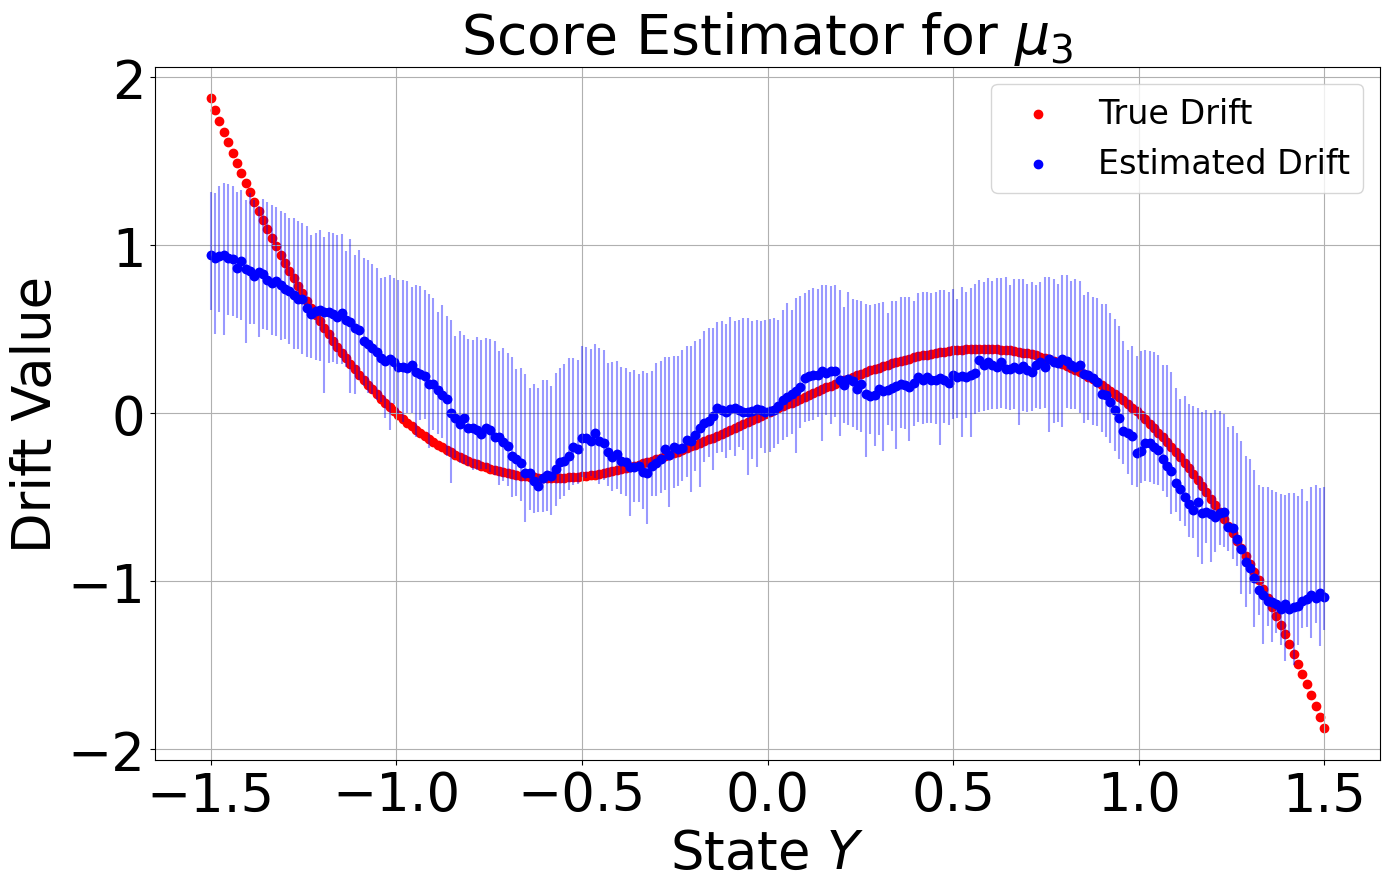

516
(2, 100, 257, 1)


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_23546/3245710472.py:43: RuntimeWarning: invalid value encountered in divide
  total_global_errors = np.sqrt(np.mean((all_global_errors), axis=0))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_23546/3245710472.py:44: RuntimeWarning: invalid value encountered in divide
  all_errs = np.sqrt(all_global_errors)/np.sqrt(time_steps)


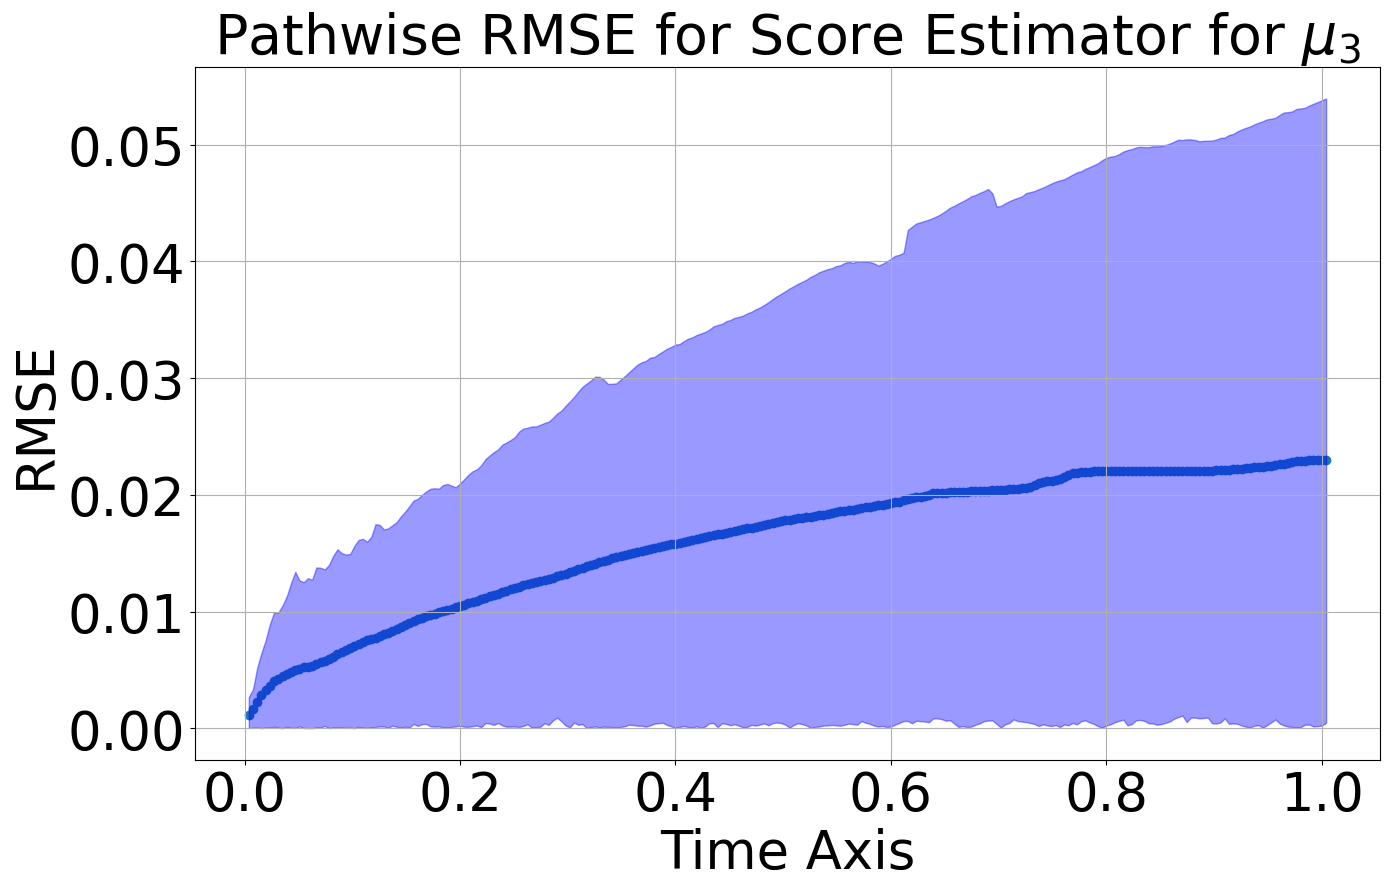

Final time cumulative MSE local-time error 0.02296610705500039 with IQR ((0.00047265673014778393, 0.05394528587486137))at Nepoch 516



In [5]:
toSave = True
eval_exps = {t: [np.inf] for t in ["BiPot", "QuadSinHF", "SinLog"]}
eval_tracks = {t: [np.inf] for t in ["BiPot", "QuadSinHF", "SinLog"]}
for config in [bipot_config]:
    Xshape = config.ts_length
    Xs = (np.linspace(-1.5,1.5,Xshape))
    root_score_dir = root_dir
    if "BiPot" in config.data_path:
        true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const)
        root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/BiPot/"
        ts_type = "BiPot"
        label = "$\mu_{3}$"
    elif "QuadSin" in config.data_path:
        true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(config.sin_space_scale * Xs))
        root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/QuadSinHF/"
        ts_type = "QuadSinHF"
        label = "$\mu_{2}$"
    elif "SinLog" in config.data_path:
        true_drifts = (-np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale)
        root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/SinLog/"
        ts_type = "SinLog"
        label = "$\mu_{1}$"
    mse = eval_exp_pipeline(root_score_dir=root_score_dir, ts_type=ts_type, config=config, root_dir=root_dir, Xs=Xs, toSave=toSave, label=label, true_drifts=true_drifts)
    eval_exps[ts_type] = [mse]
    rmse = track_pipeline(root_score_dir=root_score_dir, ts_type=ts_type, config=config, root_dir=root_dir, toSave=toSave, label=label)
    eval_tracks[ts_type] = [rmse]

In [6]:
eval_exps = (pd.DataFrame.from_dict(eval_exps))
eval_tracks = (pd.DataFrame.from_dict(eval_tracks))
print(eval_exps)
print(eval_tracks)

      BiPot  QuadSinHF  SinLog
0  0.051387        inf     inf
      BiPot  QuadSinHF  SinLog
0  0.022966        inf     inf
